In [1]:
from helper_functions import make_counts_df

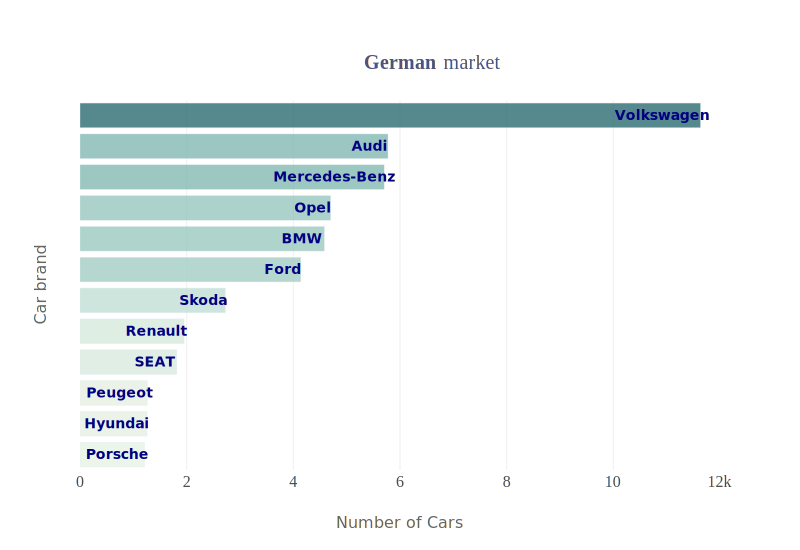

In [3]:
import os
import numpy as np
import pandas as pd
import plotly_factory as plf
import plotly.graph_objs as go

df_serbia = pd.read_csv("data\df_serbia_englang.csv")
df_germany = pd.read_csv("data\df_germany_englang.csv").sample(n=len(df_serbia))
df = pd.concat([df_serbia, df_germany], sort=False)

manufacturers_germany = plf.plot_horizontal_count_bars(
    df_germany, "manufacturer",
    first_n=12, show_percentage=False, text_position="auto",
    colorscale="mint",
)
manufacturers_germany.update_layout(
    title=plf.title_layout(
        "<b>German</b> market", title_size=20, color="#52527a"),
    yaxis=plf.axis_layout(
        "Car brand", showticklabels=False),
    xaxis=plf.axis_layout(
        "Number of Cars", tick_size=16, dtick=2000, range_=[0, 12000], show_exponent="last", show_grid=True),
)
manufacturers_germany.show(renderer="svg", width = 800, height=550)

In [5]:
models_per_manuf_serbia = make_counts_df(
    df_serbia, "manufacturer", "model", 6, 5, add_percentage=True, bold=True)
models_per_manuf_germany = make_counts_df(
    df_germany, "manufacturer", "model", 6, 5, add_percentage=True)

In [6]:
mod_per_manuf_serbia = plf.plot_table(
    models_per_manuf_serbia,
    cell_align="left", 
    header_align="center", 
    cell_height=48,
    transparent=True
)

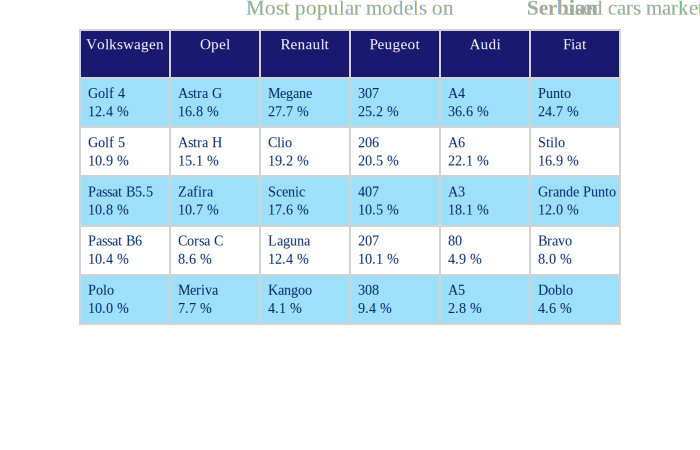

In [8]:
mod_per_manuf_serbia.layout.update(
    title=plf.title_layout(
        "Most popular models on <b>Serbian</b> used cars market", 
        y_position=1
        ),
    margin={"t":30, "b":0},
)
mod_per_manuf_serbia.show(renderer="svg")
